In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2 
import os
import shutil
from sklearn.model_selection import train_test_split
from random import shuffle 
from tqdm import tqdm 
from PIL import Image
import warnings
warnings.filterwarnings('ignore')


# The images were placed in four folders depending on if they were for testing
# or training and if they contained a bat. The images were split 15% testing
# and 85% training
train_bat = "bat_train"
train_no_bat= "no_bat_train"

In [2]:
# All images were resized to 150 X 150. This can be changed depending on how much RAM is available
image_size = 150

# Converts training images to numpy arrays and preprocesses them
def train_data():
    train_data_bat = [] 
    train_data_no_bat=[]
    for image1 in tqdm(os.listdir(train_bat)): 
        path = os.path.join(train_bat, image1)
        img1 = cv2.imread(path, cv2.IMREAD_GRAYSCALE) 
        img1 = cv2.resize(img1, (image_size, image_size))
        train_data_bat.append(img1) 
    for image2 in tqdm(os.listdir(train_no_bat)): 
        path = os.path.join(train_no_bat, image2)
        img2 = cv2.imread(path, cv2.IMREAD_GRAYSCALE) 
        img2 = cv2.resize(img2, (image_size, image_size))
        train_data_no_bat.append(img2) 
    
    train_data= np.concatenate((np.asarray(train_data_bat),np.asarray(train_data_no_bat)),axis=0)
    return train_data

train_data = train_data()
print("Processed training data")

100%|███████████████████████████████████████████████████████████████████████████| 18874/18874 [01:02<00:00, 301.95it/s]


Processed training data


In [3]:
x_data = train_data
x_data = (x_data-np.min(x_data))/(np.max(x_data)-np.min(x_data))

In [4]:
o1 = np.ones(20481)
z1 = np.zeros(18874)
Y_train = np.concatenate((o1, z1), axis=0)

In [5]:
y_data=np.asarray(Y_train).reshape(x_data.shape[0],1)
print("X shape: " , x_data.shape)
print("Y shape: " , y_data.shape)

X shape:  (39355, 150, 150)
Y shape:  (39355, 1)


In [6]:
# Split data

x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.15, random_state=42)
number_of_train = x_train.shape[0]
number_of_test = x_test.shape[0]

In [7]:
x_train_flatten = x_train.reshape(number_of_train,x_train.shape[1]*x_train.shape[2])
x_test_flatten = x_test .reshape(number_of_test,x_test.shape[1]*x_test.shape[2])
print("X train flatten",x_train_flatten.shape)
print("X test flatten",x_test_flatten.shape)
x_train = x_train_flatten.T
x_test = x_test_flatten.T
y_test = y_test.T
y_train = y_train.T
print("x train: ",x_train.shape)
print("x test: ",x_test.shape)
print("y train: ",y_train.shape)
print("y test: ",y_test.shape)

X train flatten (33451, 22500)
X test flatten (5904, 22500)
x train:  (22500, 33451)
x test:  (22500, 5904)
y train:  (1, 33451)
y test:  (1, 5904)


In [8]:
# Define functions for logistic classification

def initialize_weights_and_bias(dimension):
    w = np.full((dimension,1),0.01)
    b = 0.0
    return w, b

def sigmoid(z):
    y_head = 1/(1+np.exp(-z))
    return y_head

def forward_backward_propagation(w,b,x_train,y_train):
    # forward propagation
    z = np.dot(w.T,x_train) + b
    y_head = sigmoid(z)
    loss = -y_train*np.log(y_head)-(1-y_train)*np.log(1-y_head)
    cost = (np.sum(loss))/x_train.shape[1]
    # backward propagation
    derivative_weight = (np.dot(x_train,((y_head-y_train).T)))/x_train.shape[1]
    derivative_bias = np.sum(y_head-y_train)/x_train.shape[1]
    gradients = {"derivative_weight": derivative_weight,"derivative_bias": derivative_bias}
    return cost,gradients

def update(w, b, x_train, y_train, learning_rate,number_of_iterarion):
    cost_list = []
    cost_list2 = []
    index = []
    
    for i in range(number_of_iterarion):
        
        cost,gradients = forward_backward_propagation(w,b,x_train,y_train)
        cost_list.append(cost)
        
        w = w - learning_rate * gradients["derivative_weight"]
        b = b - learning_rate * gradients["derivative_bias"]
        if i % 100 == 0:
            cost_list2.append(cost)
            index.append(i)
            print ("Cost after iteration %i: %f" %(i, cost))
    
    parameters = {"weight": w,"bias": b}
    plt.plot(index,cost_list2)
    plt.xticks(index,rotation='vertical')
    plt.xlabel("Number of Iterarion")
    plt.ylabel("Cost")
    plt.show()
    return parameters, gradients, cost_list

def predict(w,b,x_test):
    
    z = sigmoid(np.dot(w.T,x_test)+b)
    Y_prediction = np.zeros((1,x_test.shape[1]))

    for i in range(z.shape[1]):
        if z[0,i]<= 0.5:
            Y_prediction[0,i] = 0
        else:
            Y_prediction[0,i] = 1

    return Y_prediction

def logistic_regression(x_train, y_train, x_test, y_test, learning_rate ,  num_iterations):

    dimension =  x_train.shape[0]
    w,b = initialize_weights_and_bias(dimension)

    parameters, gradients, cost_list = update(w, b, x_train, y_train, learning_rate,num_iterations)
    
    y_prediction_test = predict(parameters["weight"],parameters["bias"],x_test)
    y_prediction_train = predict(parameters["weight"],parameters["bias"],x_train)
    
    print("Test Accuracy: {} %".format(round(100 - np.mean(np.abs(y_prediction_test - y_test)) * 100,2)))
    print("Train Accuracy: {} %".format(round(100 - np.mean(np.abs(y_prediction_train - y_train)) * 100,2)))
    return parameters

Cost after iteration 0: nan
Cost after iteration 100: 0.331153
Cost after iteration 200: 0.299745
Cost after iteration 300: 0.282722
Cost after iteration 400: 0.271579
Cost after iteration 500: 0.263312
Cost after iteration 600: 0.256747
Cost after iteration 700: 0.251315
Cost after iteration 800: 0.246694
Cost after iteration 900: 0.242683
Cost after iteration 1000: 0.239148
Cost after iteration 1100: 0.235992
Cost after iteration 1200: 0.233146
Cost after iteration 1300: 0.230557
Cost after iteration 1400: 0.228185


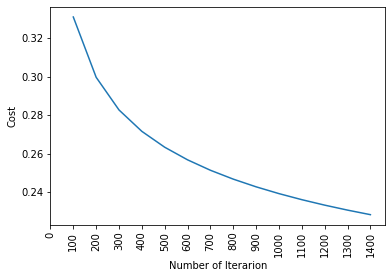

Test Accuracy: 90.94 %
Train Accuracy: 91.12 %


In [9]:
# Train model

params = logistic_regression(x_train, y_train, x_test, y_test,learning_rate = 0.01, num_iterations = 1500)

In [ ]:
# The weights and bias of the trained model can be saved for later use. After running
# this cell you should be able to find a weights.csv and bias.csv in the current
# directory. You can use these files to make predictions with the predictor.ipynb file

np.savetxt("weights.csv", params['weight'], delimiter=",")
np.savetxt("bias.csv", np.asarray([params['bias'], 0]), delimiter=",")